In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

# ElementTracers - An In-Depth Guide
<i>Preet Patel</i>

Hello, welcome to the tutorial for the Element "age" tracer module in FIRE. If you are interested in what the ElementTracers are designed for and what they do, read below. If you just want to see the dang code that makes them work, scroll on.

<b>Motivation</b>: currently, when running a simulation we have to pre-select stellar mass loss rates (how much mass does a star lose) and nucleosynthetic yields (how much of a given element does a star produce throughout its lifetime). The combination of these two can be colloquially referred to as 'feedback' from stars (though feedback also includes the energy of the explosion and how it dissapates into the surrounding interstellar medium).
Given that a Milky-way mass simulation can take many weeks/months to run from start to finish, testing variations of massloss rates and yields is prohibitively expensive. 

The element tracers take advantage of the fact that we use simulations to track the <b>number of feedback events</b> that occur for a given <b>star particle</b> as a function of its <b>age</b>. The manner in which we observe this is through the effect a feedback event has on <b>surrounding gas</b>, which records and accumulates the feedback byproducts from stars for some time before the gas itself turns into a star.

When this last step occurs, the star particle inherits the accumulated feedback events in two ways:

(1) the traditional method, where the ejecta are actually calculated and then distributed among surrounding gas

(2) the ElementTracer method, where the ejecta are not explicitly calculated, but the total 'weight' of events is preserved instead, within bins of age.

I will explain more about this later.

<b>Purpose</b>: We want to leverage these 'weights' to test variations of mass loss rates and nucleosynthetic yields in post-processing, circumventing the need to re-run a simulation with altered feedback rates.

<hr>

# How to run?

Import standard libraries:

In [2]:
from ipywidgets import interact, interactive, fixed, interact_manual
import numpy as np
import gizmo_analysis as gizmo
import utilities as ut
from matplotlib import pyplot as plt
import scipy
import ipywidgets

At the time of writing (8/3/23), you will have to manually add/replace the following two files on top of the standard installation of <a href = "https://bitbucket.org/awetzel/gizmo_analysis/src/master/">gizmo_analysis</a> from Andrew:

<b>gizmo_model.py</b> (can be found in my repo on github: https://github.com/patelpb96/GizmoElementTracers)

<b>gizmo_agetracer.py</b> (same as above, this one is derived from Andrew's version though. Ideally, at some point, these two will merge. The only major differences are my "FireYield2" class, which is built on his class and provides the functionality for altering feedback rates and nucleosynthetic yields, and a few global variables) 

Here's what my gizmo_analysis class/folder generally looks like (not every last file, but all the .py ones besides setup.py)

<img src ="https://i.imgur.com/nriNegs.png">

## 0.0 : Diagnostics, run this to be sure everything is atleast loading in and looks right

Check to see if the libraries are importing. Once they're imported, run the following to test if gizmo_model is working as intended. It will just plot the mass loss rates and nucleosynthetic yields that I've already put into the code, without assuming any progenitor metallicity (Z = 1). 

### 0.1 : basic testing of gizmo_model

See if the code below runs. Should get a list of elements tracked by FIRE, or atleast the implementation that includes Asplund 1999.

In [3]:
elem = None #'None' - No specific element, otherwise specify one of 'metals', 'iron', etc.

winds = gizmo.gizmo_model.feedback(source = 'wind', elem_name = elem) # initializing a class for Stellar Winds
ccsn = gizmo.gizmo_model.feedback(source = 'cc', elem_name = elem) #initializing a class for CCSN
wdsn = gizmo.gizmo_model.feedback(source = 'wd', elem_name = elem) #initializing a class for Type Ia/WDSN 
wdsn_mannucci = gizmo.gizmo_model.feedback(source = 'wd', elem_name = elem, ia_model = 'mannucci') #initializing a class for Type Ia/WDSN 

solar_values = gizmo.gizmo_model.get_sun_massfraction() # abundances of elements in the sun
#EYD = gizmo.gizmo_model.EventYieldDictionary() #nucleosynthetic yields of each element tracked by FIRE

element_names = [element_name.lower() for element_name in solar_values]
print("Available Elements:\n", element_names)

FYC2 = gizmo.gizmo_agetracer.FIREYieldClass2()

Available Elements:
 ['metals', 'helium', 'carbon', 'nitrogen', 'oxygen', 'neon', 'magnesium', 'silicon', 'sulfur', 'calcium', 'iron']


#### Expected result (compare with above):

     Available Elements:
     ['metals', 'helium', 'carbon', 'nitrogen', 'oxygen', 'neon', 'magnesium', 'silicon', 'sulfur', 'calcium', 'iron']

We can also plot the rates that have already been implemented. These a <i>fractional mass-loss rates</i>, which most succinctly refers to the fraction of mass lost by a star particle as a function of the age of the population, divided by the IMF-averaged mass of stars at that age. More on this below.

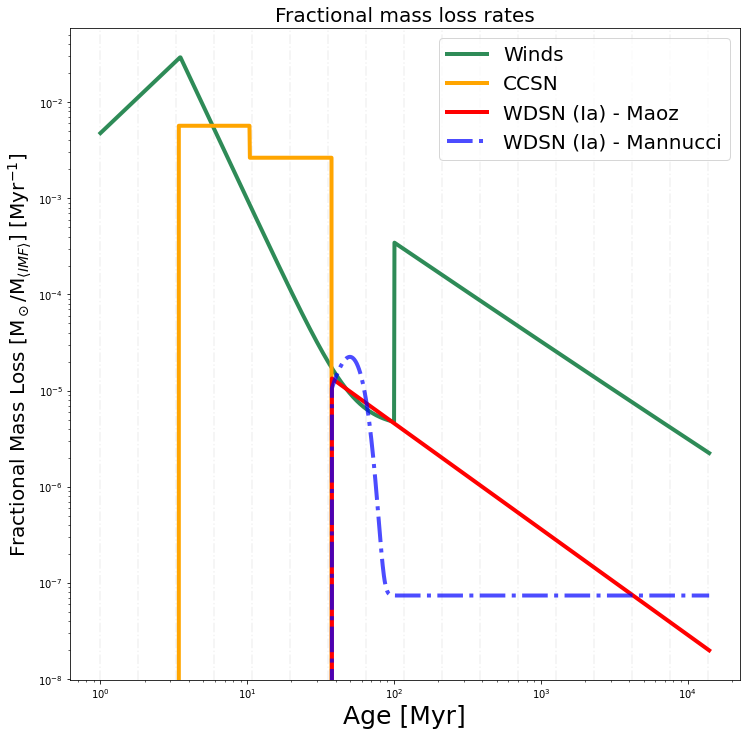

In [4]:
# rate_X = massloss rate, ages_X = total timespan, or 0 to 13.7 Gyr, d_X is the array of times at which there 
# are discontinuities in the ages. For more info, see the return values in:
# gizmo_model.py -> feedback -> get_rate_X

agebins = np.logspace(np.log10(1),np.log10(13700),17)
agebinning = True

rate_wind, ages_wind, d_wind = winds.get_rate_wind()
rate_ccsn, ages_ccsn, d_ccsn = ccsn.get_rate_cc()
rate_wdsn, ages_wdsn, d_wdsn = wdsn.get_rate_wd() # Maoz
rate_wdsn_m, ages_wdsn_m, d_wdsn_m = wdsn_mannucci.get_rate_wd() # Mannucci

fig, (ax1) = plt.subplots(1,1, figsize = (12,12))

# code to display age bins, roughly
if agebinning == True:
    for i in agebins:
        ax1.axvline(i, ls = "-.", c = 'k', alpha = 0.05)
        
ax1.loglog()
ax1.plot(ages_wind, rate_wind, lw = 4, c = 'seagreen', label = "Winds")
ax1.plot(ages_ccsn, rate_ccsn, lw = 4, c = 'orange', label = "CCSN")
ax1.plot(ages_wdsn, rate_wdsn, lw = 4, c = 'r', label = "WDSN (Ia) - Maoz")
ax1.plot(ages_wdsn_m, rate_wdsn_m, lw = 4, c = 'b', alpha = 0.7, ls = "-.", label = "WDSN (Ia) - Mannucci")

ax1.legend(fontsize = 20)
ax1.set_title("Fractional mass loss rates", size = 20)
ax1.set_xlabel("Age [Myr]", size = 25)
ax1.set_ylabel(r"Fractional Mass Loss [M$_\odot$/M$_{\langle IMF \rangle}$] [Myr$^{-1}$]", size = 20)
plt.show()

For any given star particle, here is the fraction of mass that is lost relative to the IMF-averaged mass of all stars at that age.

"IMF" refers to the "initial mass function", which determines the distribution of masses of stars in a population. Nice overview by Phil: https://ned.ipac.caltech.edu/level5/March18/Hopkins/Hopkins2.html

But you will learn the IMF the best by trying to plot out and calculate values yourself. Problem 2.5 in "Galaxies in the Universe" by "Sparke and Gallagher" is a great review of the IMF and how to use it. 

Complimentary to the above plot, the one below should plot the <b>relative amount of each element produced</b> by each type of feedback event. That is, the fraction of mass that goes into the event relative to the IMF-averaged mass of a star at that age. 

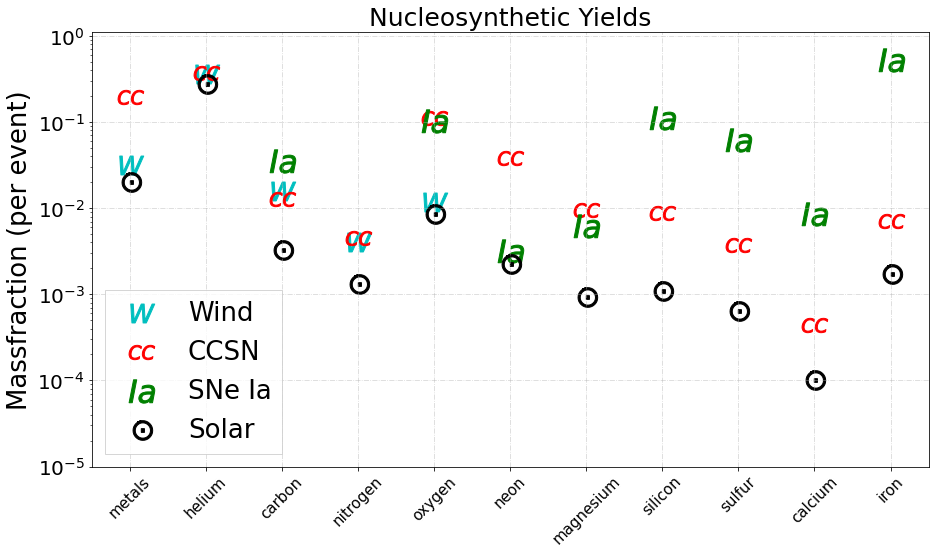

In [5]:
gizmo.gizmo_model.EventYieldDictionary.plot_yields()

### 0.2 : basic testing of gizmo_agetracer 

The class I developed to enable easy variations of the ElementTracers is called "FIREYieldClass2" at the time of writing.

In [6]:
FYC2 = gizmo.gizmo_agetracer.FIREYieldClass2()

# 1.0 Loading in an Agetracer Sim and Varying the Rates 

Feel free to use my function for loading in a particle dictionary, but of course use whatever method works best for you. See gizmo_tutorial.ipynb for more details on this step

In [7]:
# Dictionary with galaxy name and corresponding local directory containing the HDF5 - for ease of access. 

dirs = { 'm11b_hires' : 'D:\Data\m11b_res260' , 'm11q' : 'D:\Data\m11q_res880', 
       'm11h' : 'D:\Data\m11h_res880', 'm10v' : 'D:\Data\m10v_res250',
       'm11d' : 'D:\Data\m11d_res7100', 'm12i' : 'D:\Data\m12i_res7100',
       'm12i_low_res' : 'D:\Data\m12i_res57000', 'm11e' : 'D:\Data\m11e_res7100',
       'm11i' : 'D:\Data\m11i_res7100', 'm10q' : 'D:\Data\m10q_res250',
       'm09' : 'D:\Data\m09_res30', 'm11b_cr' : 'D:\Data\m11b_res2100_v2', 'm11b' : 'D:\Data\m11bfin',
       'm12i_age' : 'D:\Data\m12i_agetrace', 'm12i_maoz' : 'D:\Data\m12i_res57000_snia-maoz'}


# Function below loads the snapshot 600 from the directory that it has been assigned to. Simply use the galaxy's name
# in lowercase to get your data.

def load(galaxy):
    
    print('LOADING GALAXY: ' + galaxy + " in " + dirs[galaxy])
    
    part = gizmo.io.Read.read_snapshots(['star'], 'index', 600, assign_hosts = 'mass', 
                                        assign_hosts_rotation=True,
                                        simulation_name=str(galaxy), 
                                        simulation_directory=dirs[galaxy], 
                                        particle_subsample_factor=None) #, assign_formation_coordinates = True
    
    species='star'

    return part

In [8]:
part = load('m12i_age')

LOADING GALAXY: m12i_age in D:\Data\m12i_agetrace

# in utilities.simulation.Snapshot():
* reading:  D:\Data\m12i_agetrace/snapshot_times.txt

  using snapshot index = 600, redshift = 0.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  D:\Data\m12i_agetrace/output\snapshot_600.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 8820344 particles
    dark2     (id = 2): 3081337 particles
    gas       (id = 0): 5942109 particles
    star      (id = 4): 3068136 particles
    blackhole (id = 5): 0 particles

* reading the following
  species: ['star']

* reading particles from:
    D:\Data\m12i_agetrace/output\snapshot_600.hdf5

! cannot find MUSIC config file:  D:\Data\m12i_agetrace/*/*.conf
! missing cosmological parameters, assuming the following (from AGORA):
  assuming sigma_8 = 0.807
  assuming n_s = 0.961

* checking sanity of particle properties


# in utilities.particle.get_center_positions():
* assigning position for 1 center/host

## 1.1 Sanity Check

The code below should run if you've loaded in a simulation with element tracers. You'll typically see 16 age bins (17 points/indices) from 1 Myr to 13700 Myr in logspace. Other basic diagnostic information available below.

In [9]:
print('number of age bins = {}'.format(part.info['agetracer.age.bin.number']))

# if age-tracer model used bins equally spaced in log age (which is the default), the min and max age of these bins [Myr] (though GizmoAnalysis will over-ride the age min to be 0)
if 'agetracer.age.min' in part.info:
    print('age min,max = {}, {} Myr'.format(part.info['agetracer.age.min'], part.info['agetracer.age.max']))

# alternately, if the simulation used custom age bins, this lists them
if 'agetracer.age.bins' in part.info:
    print('age bins = {}'.format(part.info['agetracer.age.bins']))

# targeted number of age-tracer injection events per age bin
# if <= 0, this means Gizmo deposited weights at each timestep
print('targeted number of events per age bins = {}'.format(part.info['agetracer.event.number.per.age.bin']))

#part['gas'].ElementAgeTracer = gizmo.agetracer.ElementAgeTracerClass(part.info)
part['star'].ElementAgeTracer = gizmo.agetracer.ElementAgeTracerClass(part.info)

print(part['star'].ElementAgeTracer.keys())
print(part['star'].ElementAgeTracer['age.bins'])
#print(gizmo.agetracer.ElementAgeTracerClass.assign_element_initial_massfraction(part['star']))
species_name = 'star'

sun_massfraction = gizmo.gizmo_model.get_sun_massfraction()
element_names = [element_name.lower() for element_name in sun_massfraction]

number of age bins = 16
age min,max = 1.0, 13700.0 Myr
targeted number of events per age bins = 10.0
dict_keys(['has.custom.age.bin', 'event.number.per.age.bin', 'age.bin.number', 'age.bins', 'element.index.start', 'yield.massfractions', 'initial.massfraction'])
[0.00000000e+00 1.81361473e+00 3.28919840e+00 5.96533869e+00
 1.08188261e+01 1.96211825e+01 3.55852657e+01 6.45379622e+01
 1.17046999e+02 2.12278162e+02 3.84990803e+02 6.98224992e+02
 1.26631113e+03 2.29660053e+03 4.16514856e+03 7.55397480e+03
 1.37000000e+04]


All that is meant by these 'age bins' is that we can divide the timeline feedback rates for a star particle into some number of intervals in logspace. The standard right now is 16 bins. Every star/gas particle has some empty array with 16 spots, i.e.

    weights = [0,0,0,0,0,0,0,0,0,0,0,0,0,0]

If a star particle forms and experiences a supernova event 40 Myr after it forms, then the 'weight' of that event is split into some geometric fraction surrounding the star particle.

<img src = "images/AgeTracer_Weights.png">

Based on the age of the star particle ejecting the ejecta, a surrounding gas particle will update its weights-array corresponding to the age at which the star particle experienced an event. 

<img src = "images/et_weights2.png">

So the weights-array may look like this if a star particle experiences a supernova or wind event within the first 6 Myr of its existence, and deposits some ejecta into an adjacent gas cell (values are not drawn from simulation, just illustrative):

    weights = [0,0.0013,0.091,0,0,0,0,0,0,0,0,0,0,0]



we can integrate over the assumed mass loss rates and multiply them by the weight to reverse engineer the total ejecta contained within a star, and therefore, the relative abundance of elements within it. 

## 1.2 Generate Yield Dictionaries

This is where you generate Yield Dictionaries based on the feedback model you want to implement. Initialize the class using the following code. 

    fya_def = gizmo.agetracer.FIREYieldClass2('fire2.1')
    fya_2 = gizmo.agetracer.FIREYieldClass2('fire2.1', tdd_ia = -0.9)
    
The first is the agetracer class with default FIRE-2 values (+ Maoz)
The second is a slightly altered delay-time-distribution-exponent. Since the rate of WDSN $\text{rate} \propto t^{\sim 1.1}$ (based on theory and observation), we must treat the age-tracers as a <b>perturbative</b> model.

We try $\text{tdd_ia} = -0.9$ to see the effects. So fya_def will be the control, and fya_2 will guide the alteration.

In [10]:
fya_def = gizmo.agetracer.FIREYieldClass2('fire2.1')
eyd_def = fya_def.get_element_yields(part['star'].ElementAgeTracer['age.bins'], continuous = True)

fya_2 = gizmo.agetracer.FIREYieldClass2('fire2.1', ia_type = "maoz", tdd_ia = -0.9)
eyd_2 = fya_2.get_element_yields(part['star'].ElementAgeTracer['age.bins'], continuous = True)

fya_3 = gizmo.agetracer.FIREYieldClass2('fire2.1', ia_type = "maoz", normalization_ccsn = [0, 0.0006408, 0.0001516, 0])
eyd_3 = fya_3.get_element_yields(part['star'].ElementAgeTracer['age.bins'], continuous = True)

for elem in ['metals', 'iron', 'oxygen']:
    print("(WDSN ALTERATION) Ratio of Element Yield Dictionaries - " + str(elem) + "\n" + str(eyd_def[elem]/eyd_2[elem]) + "\n")
    
for elem in ['metals', 'iron', 'oxygen']:
    print("(CCSN ALTERATION) Ratio of Element Yield Dictionaries - " + str(elem) + "\n" + str(eyd_def[elem]/eyd_3[elem]) + "\n")

(WDSN ALTERATION) Ratio of Element Yield Dictionaries - metals
[1.         1.         1.         1.         1.         1.
 1.24062182 1.4594311  1.19755549 1.13125887 1.0674143  1.00617727
 0.94768187 0.89204087 0.83934654 0.78967248]

(WDSN ALTERATION) Ratio of Element Yield Dictionaries - iron
[       nan        nan 1.         1.         1.         1.
 1.56299384 1.62998064 1.44701635 1.28458969 1.14039532 1.01238667
 0.89874691 0.79786314 0.70830352 0.6287969 ]

(WDSN ALTERATION) Ratio of Element Yield Dictionaries - oxygen
[1.         1.         1.         1.         1.         1.
 1.02090604 1.1299219  1.03172021 1.02170483 1.01148477 1.00108443
 0.99053519 0.9798764  0.96915651 0.9584344 ]

(CCSN ALTERATION) Ratio of Element Yield Dictionaries - metals
[1.         1.         0.88503309 0.87023867 1.63955721 1.65641332
 1.29017322 1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]

(CCSN ALTERATION) Ratio of Element Yield Dictionaries - ir

<ipython-input-10-5e11cf2793c5>:11: RuntimeWarning: invalid value encountered in true_divide
  print("(WDSN ALTERATION) Ratio of Element Yield Dictionaries - " + str(elem) + "\n" + str(eyd_def[elem]/eyd_2[elem]) + "\n")
<ipython-input-10-5e11cf2793c5>:14: RuntimeWarning: invalid value encountered in true_divide
  print("(CCSN ALTERATION) Ratio of Element Yield Dictionaries - " + str(elem) + "\n" + str(eyd_def[elem]/eyd_3[elem]) + "\n")


You should see in the print statement at the end that varying the time delay (tdd_ia) yields a dictionary with differing amounts of metals from the default values. This is not the case in the first 4 or 5 bins, because WDSN have not started yet, so we would not expect any variation.

In [11]:
part[species_name].ElementAgeTracer.assign_element_yield_massfractions(eyd_def)

at_FeH = part[species_name].prop('metallicity.agetracer.fe')
at_MgFe = part[species_name].prop('metallicity.agetracer.mg - metallicity.agetracer.fe')

############################################################################################
part[species_name].ElementAgeTracer.assign_element_yield_massfractions(eyd_2, flush = True)

at_FeH2 = part[species_name].prop('metallicity.agetracer.fe')
at_MgFe2 = part[species_name].prop('metallicity.agetracer.mg - metallicity.agetracer.fe')
############################################################################################
part[species_name].ElementAgeTracer.assign_element_yield_massfractions(eyd_3, flush = True)

at_FeH3 = part[species_name].prop('metallicity.agetracer.fe')
at_MgFe3 = part[species_name].prop('metallicity.agetracer.mg - metallicity.agetracer.fe')

C:\Users\patel\OneDrive\Desktop\research2\gizmo_analysis\gizmo_io.py:298: RuntimeWarning: invalid value encountered in subtract
  prop_values = prop_values - self.prop(prop_name, indices)


NOTE: After you generate the first element yield dictionary and corresponding abundances, you can't overwrite it with a new one out the box, something about the particle dictionary generation makes it immutable. There are atleast two solutions: one is to add another array(s) which correspond to a given feedback model and to make sure you are reading in the correct index/indices. Another is to remove those dictionary values and to generate new element yields. 

The more seamless solution for me was to do the latter, I added a 'flush' parameter which allows you to overwrite the previously-written dictionary. I haven't set it to "True" as default because I worry about unintended effects, but I have made it pretty easy to pass when using the ElementTracers.

## 1.3 Plot Results in Elemental Abundance Space: [Mg/Fe] vs [Fe/H]

Now I can plot the results of making a variation to the time-delay-distribution of Ia's and see what effect it may have on the final yields at present day. It is not necessary at all for you to make plots in the manner I have shown below, but I feel it may be helpful for a reader if I lay out basically every line of code and then plot it in a 2x1 plot. 

In [19]:
def plot_vals(X1,Y1,X2,Y2,X3=None,Y3=None, 
              include_winds = True, 
              include_cc = True, 
              include_wd = True, 
              include_wd2 = True, 
              include_cc2 = True,
              mannucci = False,
              tdd = -0.9, # default : -1.1
              nccs = [0, 0.0006408, 0.0001516, 0], # default : [0, 0.0005408, 0.0002516, 0]
              axes1lim = [[-3,1],[-0.25,0.375]]):
    
    i = None
    str_title = 'Total'

    fig, (ax1,ax2) = plt.subplots(1,2, figsize = (16,8))

    _wind = gizmo.gizmo_model.feedback(source = 'wind', elem_name = i)
    _wd = gizmo.gizmo_model.feedback(source = 'ia', elem_name = i, ia_model = 'maoz')
    _wd2 = gizmo.gizmo_model.feedback(source = 'ia', elem_name = i, t_dd = tdd, ia_model = 'maoz')
    _wd_man = gizmo.gizmo_model.feedback(source = 'ia', elem_name = i, ia_model = 'mannucci')

    _ccsn = gizmo.gizmo_model.feedback(source = 'cc', elem_name = i)
    _ccsn2 = gizmo.gizmo_model.feedback(source = 'cc', n_cc = nccs, elem_name = i)

    r_wind, a_wind, t_wind = _wind.get_rate_wind()
    
    r_wd, a_wd, t_wd = _wd.get_rate_wd()
    r_wd2, a_wd2, t_wd2 = _wd2.get_rate_wd()
    r_man, a_man, t_man = _wd_man.get_rate_wd()
    
    r_cc, a_cc, t_cc = _ccsn.get_rate_cc()
    r_cc2, a_cc2, t_cc2 = _ccsn2.get_rate_cc()

    
    wd_int = scipy.integrate.cumtrapz(r_wd, a_wd)
    wd_int2 = scipy.integrate.cumtrapz(r_wd2, a_wd2)
    cc_int = scipy.integrate.cumtrapz(r_cc, a_cc)
    cc_int2 = scipy.integrate.cumtrapz(r_cc2, a_cc2)

    
    # Normalizing the WDSN/SNe Ia rates. Same with CC
    N_fid = (wd_int[-1])
    _N_var = (wd_int2[-1])
    A = N_fid / _N_var
    N_var = A*_N_var

    N_fid_cc = (cc_int[-1])
    _N_var_cc = (wd_int2[-1])
    A_cc = N_fid_cc / _N_var_cc
    N_var_cc = A_cc*_N_var_cc
    
    subsample = 10
    ax1.scatter(X1[::subsample], Y1[::subsample], s = 1, c = 'k', alpha = 0.1)
    ax1.scatter(-6,0,s = 35, c = 'k', label = r"default")

    ax1.set_xlabel("[Fe/H]", size = 20)
    ax1.set_ylabel("[Mg/Fe]", size = 20)
    ax1.set_xlim(axes1lim[0][0],axes1lim[0][1])
    ax1.set_ylim(axes1lim[1][0],axes1lim[1][1])

    ax2.loglog()
    
    if X3 is False:
        if Y3 is False:
            include_cc2 = False
    
    if include_winds:
        ax2.plot(a_wind, r_wind, lw = 4, c = 'seagreen', label = "Winds")
        
    if include_cc:
        ax2.plot(a_cc, r_cc, lw = 4, c = 'orange', label = "CCSN")
    if include_cc2:
        ax2.plot(a_cc2, r_cc2, lw = 4, c = 'k', ls = ":", label = r"CCSN$_2$")
        ax1.scatter(-6,0,s = 35, c = 'orange', label = r"CCSN$_2$")
        ax1.scatter(X3[::subsample], Y3[::subsample], s = 1, c = 'orange', alpha = 0.1)

    if mannucci:
        include_wd = False
        ax2.plot(a_man, r_man, lw = 4, c = 'r', label = "WDSN (Ia)")

    if include_wd:
        ax2.plot(a_wd, r_wd, lw = 4, c = 'r', label = "WDSN (Ia)")

    if include_wd2:
        ax2.plot(a_wd2, A*r_wd2, lw = 4, c = 'k', ls = "-.", label = r"WDSN$_2$ (Ia)")
        ax1.scatter(-6,0,s = 35, c = 'r', label = r"WDSN$_2$")
        ax1.scatter(X2[::subsample], Y2[::subsample], s = 1, c = 'r', alpha = 0.1)

    ax1.legend(fontsize = 20, loc = 3)
    ax2.legend(fontsize = 20, loc = 1)
    ax2.set_title("Fractional mass loss rates: " + str_title, size = 20)
    ax2.set_xlabel("Age [Myr]", size = 25)
    ax2.set_ylabel(r"Fractional Mass Loss [M$_\odot$/M$_{\langle IMF \rangle}$] [Myr$^{-1}$]", size = 20)
    ax2.set_ylim(1e-8,9e-1)
    plt.show()

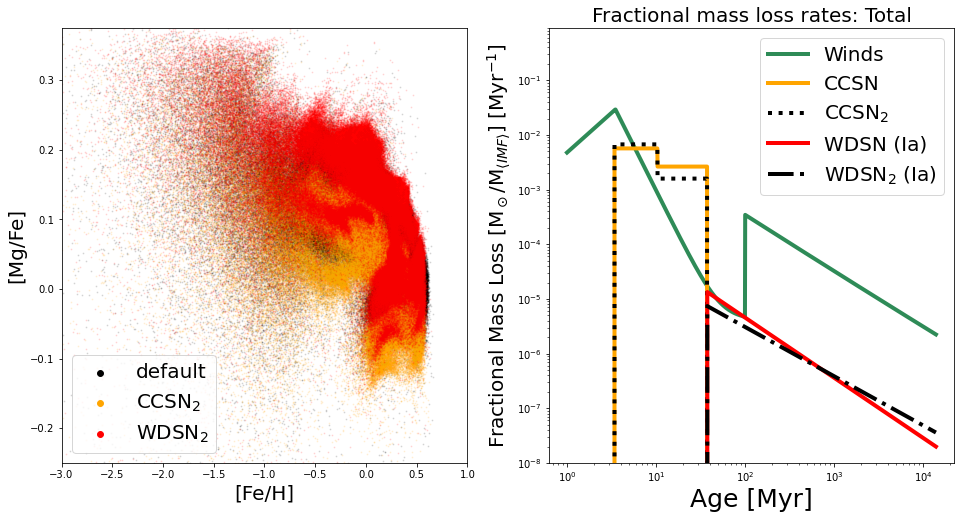

In [20]:
plot_vals(at_FeH, at_MgFe, at_FeH2, at_MgFe2, at_FeH3, at_MgFe3)

### Fig 3

On the left, I've plotted [Fe/H] on the x-axis and [Mg/Fe] on the Y. I did not plot native FIRE-2 abundances, and everything here has been run through the ElementTracer pipeline. The red dots represent the default <i>feedback models</i>, while the black dots represent an alteration of the WDSN rate. 

On the right, you can see the fractional massloss rates of Winds (green), CCSN (orange), and WDSN (red). <b>The black, dashed line</b> represents the altered rate over which I integrate to generate a new set of elemental abundances. <b>NOTE: </b>I have normalized this rate so that the <i>total number</i> of Type Ia/WDSN is preserved. You can see a manual implementation of this in lines 24-29 in plot_vals() above, which I've pasted below:

    # Normalizing the WDSN/SNe Ia rates. Same with CC
    N_fid = (wd_int[-1])
    _N_var = (wd_int2[-1])
    N_fid_cc = (cc_int[-1])
    A = N_fid / _N_var
    N_var = A*_N_var
    
However this is built into gizmo_agetracer for actually generating new yield dictionaries. You should be able alter the CCSN rate as well while preserving the number.

## 1.4 Interactive Plots

This is just for fun. You might want to read up on ipywidgets and interactive functions if you're not sure what's going on. I find that quick and effective visualization is a great way to wrap one's head around things (scroll through the options for _tdd).

In [25]:
@interact(_tdd = [-1.5,-1.3,-1.1,-0.9,-0.7,-0.5],
          _ia_type = ['maoz','mannucci'],
          _n_ccsns = [[0, 0.0006408, 0.0001516, 0],[0, 0.0005408, 0.0002516, 0],[0, 0.0004408, 0.0003516, 0]])
def ia_and_cc_variation_plot(_tdd = -1.1, _ia_type = 'maoz', _n_ccsns = [0, 0.0005408, 0.0002516, 0]):
    
    #Step 1, intialized agetracer class from gizmo_agetracer
    fya_def = gizmo.agetracer.FIREYieldClass2('fire2.1')
    
    #Step 2, integrate and generate yield dictionary
    eyd_def = fya_def.get_element_yields(part['star'].ElementAgeTracer['age.bins'], continuous = True)

    #Step 3, Repeat for model with alterations to feedback rate model
    fya_3 = gizmo.agetracer.FIREYieldClass2('fire2.1', ia_type = _ia_type, tdd_ia = _tdd)
    eyd_3 = fya_3.get_element_yields(part['star'].ElementAgeTracer['age.bins'], continuous = True)
    
    fya_4 = gizmo.agetracer.FIREYieldClass2('fire2.1', ia_type = "maoz", normalization_ccsn = _n_ccsns)
    eyd_4 = fya_4.get_element_yields(part['star'].ElementAgeTracer['age.bins'], continuous = True)
    ############################################################################################
    
    #Step 4, assign these yields to the particle dictionary
    part[species_name].ElementAgeTracer.assign_element_yield_massfractions(eyd_def, flush = True)

    #Step 5, generate abundances
    at_FeH = part[species_name].prop('metallicity.agetracer.fe')
    at_MgFe = part[species_name].prop('metallicity.agetracer.mg - metallicity.agetracer.fe')
    ############################################################################################
    
    #Step 6, repeat Steps 4 and 5, but now for the altered feedback rate model
    part[species_name].ElementAgeTracer.assign_element_yield_massfractions(eyd_3, flush = True)

    at_FeH3 = part[species_name].prop('metallicity.agetracer.fe')
    at_MgFe3 = part[species_name].prop('metallicity.agetracer.mg - metallicity.agetracer.fe')
    
    #Step 6, repeat Steps 4 and 5, but now for the altered feedback rate model
    part[species_name].ElementAgeTracer.assign_element_yield_massfractions(eyd_4, flush = True)

    at_FeH4 = part[species_name].prop('metallicity.agetracer.fe')
    at_MgFe4 = part[species_name].prop('metallicity.agetracer.mg - metallicity.agetracer.fe')
    
    # Plot
    if _ia_type == 'mannucci':
        plot_vals(at_FeH, at_MgFe, at_FeH3, at_MgFe3, at_FeH4, at_MgFe4, nccs = _n_ccsns, tdd = _tdd, mannucci=True)
    else:
        plot_vals(at_FeH, at_MgFe, at_FeH3, at_MgFe3, at_FeH4, at_MgFe4, nccs = _n_ccsns, tdd = _tdd)

interactive(children=(Dropdown(description='_tdd', index=2, options=(-1.5, -1.3, -1.1, -0.9, -0.7, -0.5), valu…

<hr>

## 2.0 Isolating Feedback Channels 

Say we want to evaluate JUST the contribution from winds, or JUST the contribution from CCSN/WDSN. How can we do that?

Well, we can assign yields based on just one of those channels with the <font face="courier new">testing</font> parameter:

    FIREYield.get_element_yields(part_cc['star'].ElementAgeTracer['age.bins'], testing = 'cc')
    FIREYield.get_element_yields(part_cc['star'].ElementAgeTracer['age.bins'], testing = 'ia')
    FIREYield.get_element_yields(part_cc['star'].ElementAgeTracer['age.bins'], testing = 'winds')
    
    
## 2.1 Massfractions Using Isolated Feedback Channels

Say we load two element yield dictionaries, one that solely integrates over the CCSN and another which solely integrates over WDSN rates. We can use the above to initialize the element yield dictionary and then generation massfractions in metals for stars. Each star will have a final metal value that corresponds to a subset of feedback rates (aka, one which only includes one feedback channel). This allows us to assess what the relative contribution of CCSN is versus that of WDSN (for example). In theory you can mix and match, and I've even add 'no_winds', 'no_cc', and 'no_wd' as valid parameters for this function. It can be found in gizmo_agetracer.py, under:

    _get_element_yield_rate()


In [38]:
FIREYield = gizmo.agetracer.FIREYieldClass2('fire2.1', ia_type='maoz') 
eabins = part['star'].ElementAgeTracer['age.bins']

# Yield dictionaries for just CCSN, just WDSN, and just WINDS
Element_Yield_Dictionary_CCSN = FIREYield.get_element_yields(eabins, testing = 'cc', continuous = True)
Element_Yield_Dictionary_WDSN = FIREYield.get_element_yields(eabins, testing = 'ia', continuous = True)
Element_Yield_Dictionary_WINDS = FIREYield.get_element_yields(eabins, testing = 'wind', continuous = True)

# NOTE: flush = True when performing this set of operations
part['star'].ElementAgeTracer.assign_element_yield_massfractions(Element_Yield_Dictionary_CCSN, flush = True)
cc_metal_massfraction = part['star'].prop('massfraction.agetracer.metals')

part['star'].ElementAgeTracer.assign_element_yield_massfractions(Element_Yield_Dictionary_WDSN, flush = True)
wd_metal_massfraction = part['star'].prop('massfraction.agetracer.metals')

part['star'].ElementAgeTracer.assign_element_yield_massfractions(Element_Yield_Dictionary_WINDS, flush = True)
wind_metal_massfraction = part['star'].prop('massfraction.agetracer.metals')

## 2.2 Generating Massfraction _Distributions_

Normally, when we look at the [Fe/H] or [Mg/Fe], we do so to assess the relative contribution from CCSN and WDSN. However, these are not exact measures, as CCSN don't _only_ produce Mg, and WDSN don't _only_ produce Fe. So even if a given metal abundance is highly correlated with a type of supernova, it doesn't uniquely identify with a particular process.

To get a more direct view of this, we can actually use the element-tracers. Since the quantity that is fundamentally tracked by the simulation is the massfraction within stars, we can look at how the integrated massloss rates from one process leads to some value in metals (by isolating the feedback channels as we have above). 

In [39]:
r = part['star'].prop('host.distance.principal.spherical')[:,0] #spherical radius 
z = part['star'].prop('host.distance.principal')[:,2]
feh = part['star'].prop('metallicity.fe - metallicity.h')
mgfe = part['star'].prop('metallicity.mg - metallicity.fe')

ind = np.where((r < 15) & (np.abs(z) < 3)) # Selection criteria from Bellardini et al 2022 - note that
                                           # formation radius is missing. Couldn't load it in here, but you'd 
                                           # want to select stars that form within 30 kpc
        
wd_massfrac = wd_metal_massfraction[ind] # what fraction of metals in each star comes from WDSN?
cc_massfrac = cc_metal_massfraction[ind] # what fraction of metals in each star comes from CCSN?
wind_massfrac = wind_metal_massfraction[ind] # what fraction of metals in each star comes from WINDS?
tot_massfrac = wd_massfrac + cc_massfrac + wind_massfrac # what is the total metal massfraction in each star?

I will refer to each metal mass-fraction with $f$, i.e. <font face="courier new">wd_massfrac</font> will be:

$$f_{WD}$$
We have so far found:

$$f_{WD}, f_{CC}, f_{Winds},$$

and 

$$f_{total} = f_{WD} + f_{CC} + f_{Winds}$$

If I want to see the contribution of WDSN to the total metal content of a given star, I might ask - what is:

$$\frac{f_{WD}}{f_{total}}$$

If I'm specifically interested in how supernovae effect the metal massfraction, I would ignore the contribution from winds, i.e.:

$$\frac{f_{WD}}{f_{WD} + f_{CC}}$$

I calculate such values below:

In [40]:
noWDs = np.where(wd_massfrac <= 0)[0] # indices of stars whose metal massfraction is consistent with 0 WDSN enrichment
noCCs = np.where(cc_massfrac <= 0)[0] # indices of stars whose metal massfraction is consistent with 0 CCSN enrichment

ratio_wd = wd_massfrac/tot_massfrac # what portion of the total metal enrichment comes from WDSN?
ratio_cc = cc_massfrac/tot_massfrac # what portion of the total metal enrichment comes from CCSN?

ratio_cc2 = cc_massfrac / (wd_massfrac + cc_massfrac) # same as above for CCSN, but no winds
ratio_wd2 = wd_massfrac / (wd_massfrac + cc_massfrac) # ... WDSN ...

<ipython-input-40-46294a2fc9b6>:4: RuntimeWarning: invalid value encountered in true_divide
  ratio_wd = wd_massfrac/tot_massfrac # what portion of the total metal enrichment comes from WDSN?
<ipython-input-40-46294a2fc9b6>:5: RuntimeWarning: invalid value encountered in true_divide
  ratio_cc = cc_massfrac/tot_massfrac # what portion of the total metal enrichment comes from CCSN?
<ipython-input-40-46294a2fc9b6>:7: RuntimeWarning: invalid value encountered in true_divide
  ratio_cc2 = cc_massfrac / (wd_massfrac + cc_massfrac) # same as above for CCSN, but no winds
<ipython-input-40-46294a2fc9b6>:8: RuntimeWarning: invalid value encountered in true_divide
  ratio_wd2 = wd_massfrac / (wd_massfrac + cc_massfrac) # ... WDSN ...


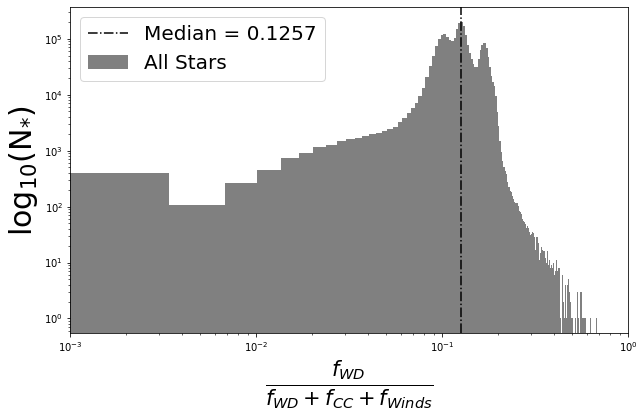

In [41]:
median = np.nanmedian(ratio_wd)
plt.figure(figsize = (10,6))
plt.hist(ratio_wd, bins = 200, color = 'gray', label = "All Stars")
plt.axvline(median, c = 'k', ls = "-.", label = "Median = " + str(round(median,4)))
plt.xlabel(r"$\frac{f_{WD}}{f_{WD} + f_{CC} + f_{Winds}}$", size = 30)
plt.ylabel(r"log$_{10}$(N$_{*}$)", size =30)
plt.legend(fontsize = 20)
plt.semilogx()
plt.semilogy()
plt.xlim(0.001,1)
plt.show()

In [42]:
print("\nCC_WD_MMF_RATIO, " + str(np.sum(cc_massfrac)/np.sum(wd_massfrac)))
print("^ massfraction ratio of CCSN / WDSN ")
print("\nRelative_CC_MMF, " + str(np.sum(cc_massfrac)/(np.sum(wd_massfrac + cc_massfrac))))
print("^ massfraction ratio of CCSN / (CCSN + WDSN) ")
print("\nRelative_WD_MMF, " + str(np.sum(wd_massfrac)/(np.sum(wd_massfrac + cc_massfrac))))
print("^ massfraction ratio of WDSN / (CCSN + WDSN) ")
print("\n CCSN are responsible for the majority of *metals* that the average star recieves from SNe (~83%)")


CC_WD_MMF_RATIO, 4.716831004325591
^ massfraction ratio of CCSN / WDSN 

Relative_CC_MMF, 0.8250779148022117
^ massfraction ratio of CCSN / (CCSN + WDSN) 

Relative_WD_MMF, 0.1749220851977886
^ massfraction ratio of WDSN / (CCSN + WDSN) 

 CCSN are responsible for the majority of *metals* that the average star recieves from SNe (~83%)


## 2.3 Comparison To Reeves et. al. 2023

<a href="https://doi.org/10.48550/arXiv.2307.05669">Reeves et al (2023)</a> find the relative fraction of stars within a galaxy that can be classified as 'Iron-rich, metal poor' (IRMP). This definition of IRMP comes from <a href="https://doi.org/10.48550/arXiv.2303.16357">Reggiani et al 2023</a>, and is summarized (for the purpose of analysis here) as:

Any star with both:

$$\text{[Fe/H] < -1}$$

$$\text{[Mg,Na/Fe] < 0}$$

"Mg,Na" just means "Either Mg OR Na", and in the Reggiani paper you will see a much longer list that I don't include since we don't track the elements.

In essence, this looks for stars that have upto 1/10th the solar abundance in Iron, and sub-solar abundance in Mg relative to Iron. The reason for this is that stars which are primarily enriched by WDSN tend to have Fe/H < -1 in simulations, and necessarily are 'iron rich' from WDSN because they are less abundant in Mg than they are in Fe. Reading the above two papers may provide additional clarity.

We seek to compare to their observational findings for the frequency of IRMP stars accross different environments, namely, galaxies spanning a total mass range from $10^{9} - 10^{12} M_\odot$. See <b><u>Table 2</u></b> in Reeves et al for more details. 

In [43]:
f_1 = len(ratio_wd[np.where((feh[ind] < -1) & (mgfe[ind] < 0))])/len(ratio_wd)
print(f_1)

v = part['star'].prop('host.velocity.principal.cylindrical')
vphi = part['star'].prop('host.velocity.principal.cylindrical')[:,1]

ind_reeves = np.where((feh[ind] < -1) & (mgfe[ind] < 0))
ind_reeves_halo = np.where((feh[ind] < -1) & (mgfe[ind] < 0) & (vphi[ind] < 50))
ind_reeves_disk = np.where((feh[ind] < -1) & (mgfe[ind] < 0) & (vphi[ind] > 50))

0.0002324394806961846


## 2.4 Massfraction comparison(s) with criteria from Reeves+23

<ipython-input-44-5ac16507364f>:32: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inchest" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("irmp_m12i_lowres.png", dpi = 150, bbox_inchest = 'tight')


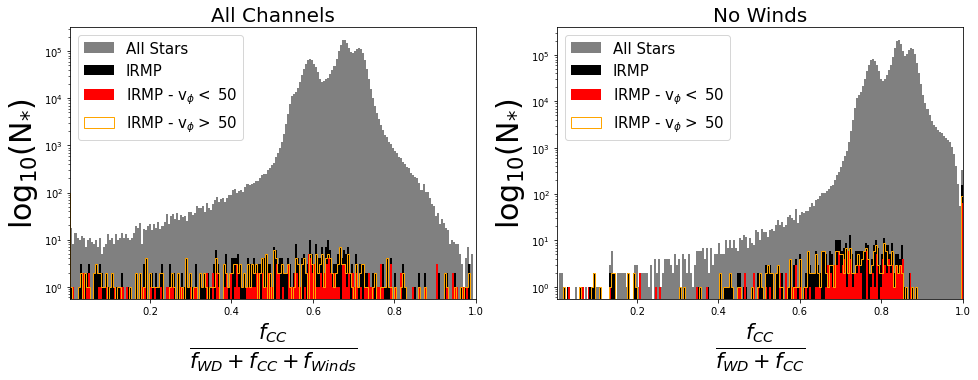

In [44]:
f_1 = len(ratio_wd[ind_reeves])/len(ratio_wd)
f_2 = len(ratio_wd[ind_reeves_halo])/len(ratio_wd)
f_3 = len(ratio_wd[ind_reeves_disk])/len(ratio_wd)

fig, (ax1,ax2) = plt.subplots(1,2, figsize = (16,5))

ax1.hist(ratio_cc, bins = 200, color = 'gray', label = "All Stars")
ax1.hist(ratio_cc[ind_reeves], color = 'k', bins = 200, label = "IRMP")
ax1.hist(ratio_cc[ind_reeves_halo], color = 'r', bins = 200, label = r"IRMP - v$_\phi <$ 50")
ax1.hist(ratio_cc[ind_reeves_disk], color = 'orange', bins = 200, histtype = 'step', label = r"IRMP - v$_\phi >$ 50")


ax1.set_xlabel(r"$\frac{f_{CC}}{f_{WD} + f_{CC} + f_{Winds}}$", size = 30)
ax1.set_ylabel(r"log$_{10}$(N$_{*}$)", size =30)
ax1.legend(fontsize = 15)
#ax1.semilogx()
ax1.semilogy()
ax1.set_xlim(4e-3,1)
ax1.set_title("All Channels", size = 20)

ax2.hist(ratio_cc2, bins = 200, color = 'gray', label = "All Stars")
ax2.hist(ratio_cc2[ind_reeves], color = 'k', bins = 200, label = "IRMP")
ax2.hist(ratio_cc2[ind_reeves_halo], color = 'r', bins = 200, label = r"IRMP - v$_\phi <$ 50")
ax2.hist(ratio_cc2[ind_reeves_disk], color = 'orange', bins = 200, histtype = 'step', label = r"IRMP - v$_\phi >$ 50")
ax2.set_xlabel(r"$\frac{f_{CC}}{f_{WD} + f_{CC}}$", size = 30)
ax2.set_ylabel(r"log$_{10}$(N$_{*}$)", size =30)
ax2.legend(fontsize = 15)
#ax2.semilogx()
ax2.semilogy()
ax2.set_xlim(4e-3,1)
ax2.set_title("No Winds", size = 20)
plt.savefig("irmp_m12i_lowres.png", dpi = 150, bbox_inchest = 'tight')
plt.show()

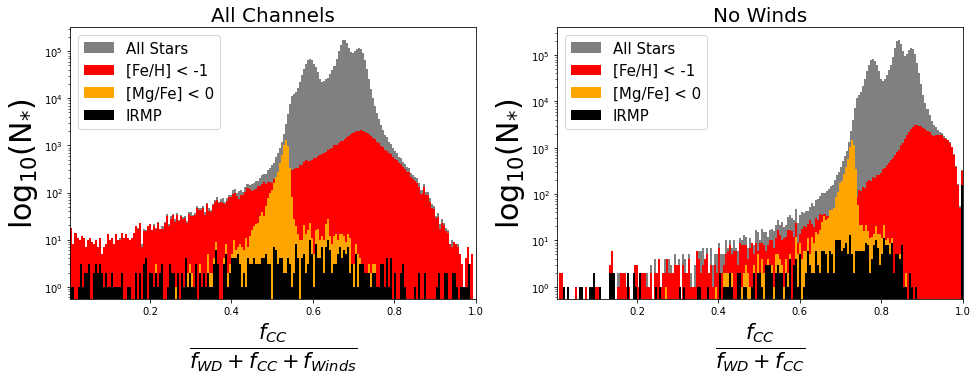

In [45]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (16,5))

ax1.hist(ratio_cc, bins = 200, color = 'gray', label = "All Stars")
ax1.hist(ratio_cc[np.where(feh[ind] < -1)], color = 'r', bins = 200, label = "[Fe/H] < -1")
ax1.hist(ratio_cc[np.where(mgfe[ind] < 0)], color = 'orange', bins = 200, label = "[Mg/Fe] < 0")
ax1.hist(ratio_cc[np.where((feh[ind] < -1) & (mgfe[ind] < 0))], color = 'k', bins = 200, label = "IRMP")
ax1.set_xlabel(r"$\frac{f_{CC}}{f_{WD} + f_{CC} + f_{Winds}}$", size = 30)
ax1.set_ylabel(r"log$_{10}$(N$_{*}$)", size =30)
ax1.legend(fontsize = 15)
#ax1.semilogx()
ax1.semilogy()
ax1.set_xlim(4e-3,1)
ax1.set_title("All Channels", size = 20)

ax2.hist(ratio_cc2, bins = 200, color = 'gray', label = "All Stars")
ax2.hist(ratio_cc2[np.where(feh[ind] < -1)], color = 'r', bins = 200, label = "[Fe/H] < -1")
ax2.hist(ratio_cc2[np.where(mgfe[ind] < 0)], color = 'orange', bins = 200, label = "[Mg/Fe] < 0")
ax2.hist(ratio_cc2[np.where((feh[ind] < -1) & (mgfe[ind] < 0))], color = 'k', bins = 200, label = "IRMP")
ax2.set_xlabel(r"$\frac{f_{CC}}{f_{WD} + f_{CC}}$", size = 30)
ax2.set_ylabel(r"log$_{10}$(N$_{*}$)", size =30)
ax2.legend(fontsize = 15)
#ax2.semilogx()
ax2.semilogy()
ax2.set_xlim(4e-3,1)
ax2.set_title("No Winds", size = 20)
    
plt.show()

In [46]:
np.sum(part['star'].prop('mass'))

158021580000.0

<ipython-input-47-5ac16507364f>:32: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inchest" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("irmp_m12i_lowres.png", dpi = 150, bbox_inchest = 'tight')


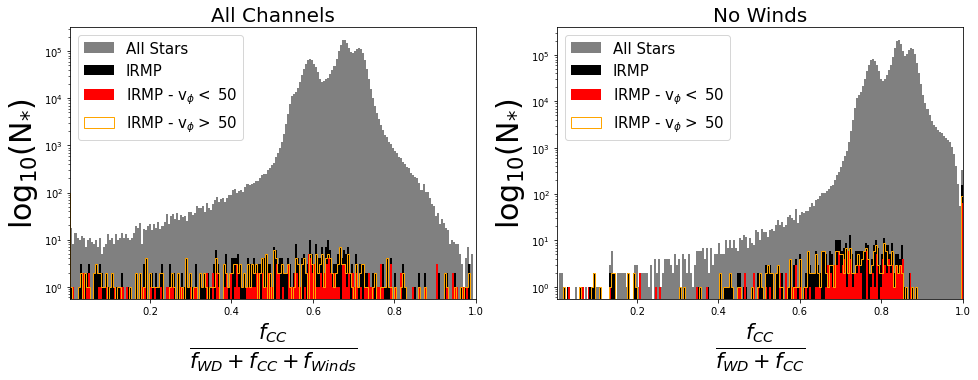

In [47]:
f_1 = len(ratio_wd[ind_reeves])/len(ratio_wd)
f_2 = len(ratio_wd[ind_reeves_halo])/len(ratio_wd)
f_3 = len(ratio_wd[ind_reeves_disk])/len(ratio_wd)

fig, (ax1,ax2) = plt.subplots(1,2, figsize = (16,5))

ax1.hist(ratio_cc, bins = 200, color = 'gray', label = "All Stars")
ax1.hist(ratio_cc[ind_reeves], color = 'k', bins = 200, label = "IRMP")
ax1.hist(ratio_cc[ind_reeves_halo], color = 'r', bins = 200, label = r"IRMP - v$_\phi <$ 50")
ax1.hist(ratio_cc[ind_reeves_disk], color = 'orange', bins = 200, histtype = 'step', label = r"IRMP - v$_\phi >$ 50")


ax1.set_xlabel(r"$\frac{f_{CC}}{f_{WD} + f_{CC} + f_{Winds}}$", size = 30)
ax1.set_ylabel(r"log$_{10}$(N$_{*}$)", size =30)
ax1.legend(fontsize = 15)
#ax1.semilogx()
ax1.semilogy()
ax1.set_xlim(4e-3,1)
ax1.set_title("All Channels", size = 20)

ax2.hist(ratio_cc2, bins = 200, color = 'gray', label = "All Stars")
ax2.hist(ratio_cc2[ind_reeves], color = 'k', bins = 200, label = "IRMP")
ax2.hist(ratio_cc2[ind_reeves_halo], color = 'r', bins = 200, label = r"IRMP - v$_\phi <$ 50")
ax2.hist(ratio_cc2[ind_reeves_disk], color = 'orange', bins = 200, histtype = 'step', label = r"IRMP - v$_\phi >$ 50")
ax2.set_xlabel(r"$\frac{f_{CC}}{f_{WD} + f_{CC}}$", size = 30)
ax2.set_ylabel(r"log$_{10}$(N$_{*}$)", size =30)
ax2.legend(fontsize = 15)
#ax2.semilogx()
ax2.semilogy()
ax2.set_xlim(4e-3,1)
ax2.set_title("No Winds", size = 20)
plt.savefig("irmp_m12i_lowres.png", dpi = 150, bbox_inchest = 'tight')
plt.show()